<a href="https://www.kaggle.com/code/ayeshairshadcoder/house-price-prediction-competition?scriptVersionId=155084309" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


In [4]:
train=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv")
test=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv")
sample_submission=pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv")

In [5]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

# Comprehensive Data Exploration

## Understanding the Target variable

In [6]:
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

+ The minimum value is greater then 0 which means no null value

<Axes: xlabel='SalePrice', ylabel='Count'>

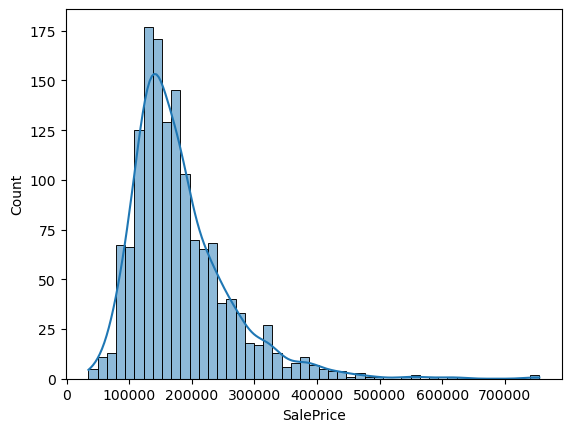

In [7]:
sns.histplot(train['SalePrice'],kde=True)

+ **The normal distribution**
+ **positive skewness**
+ **peakedness**

In [8]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


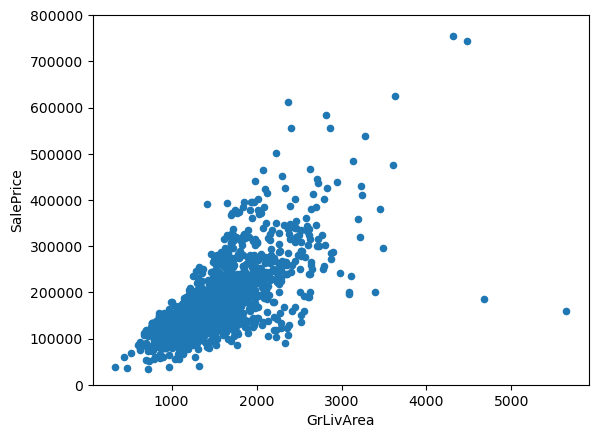

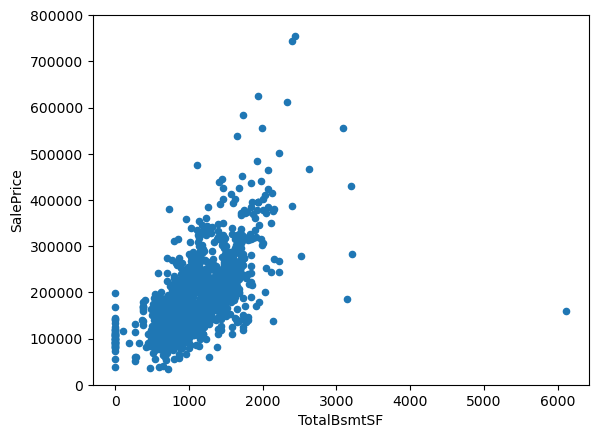

In [9]:
var = ['GrLivArea','TotalBsmtSF']
for i in var:
    train.plot.scatter(x=i, y='SalePrice', ylim=(0,800000));

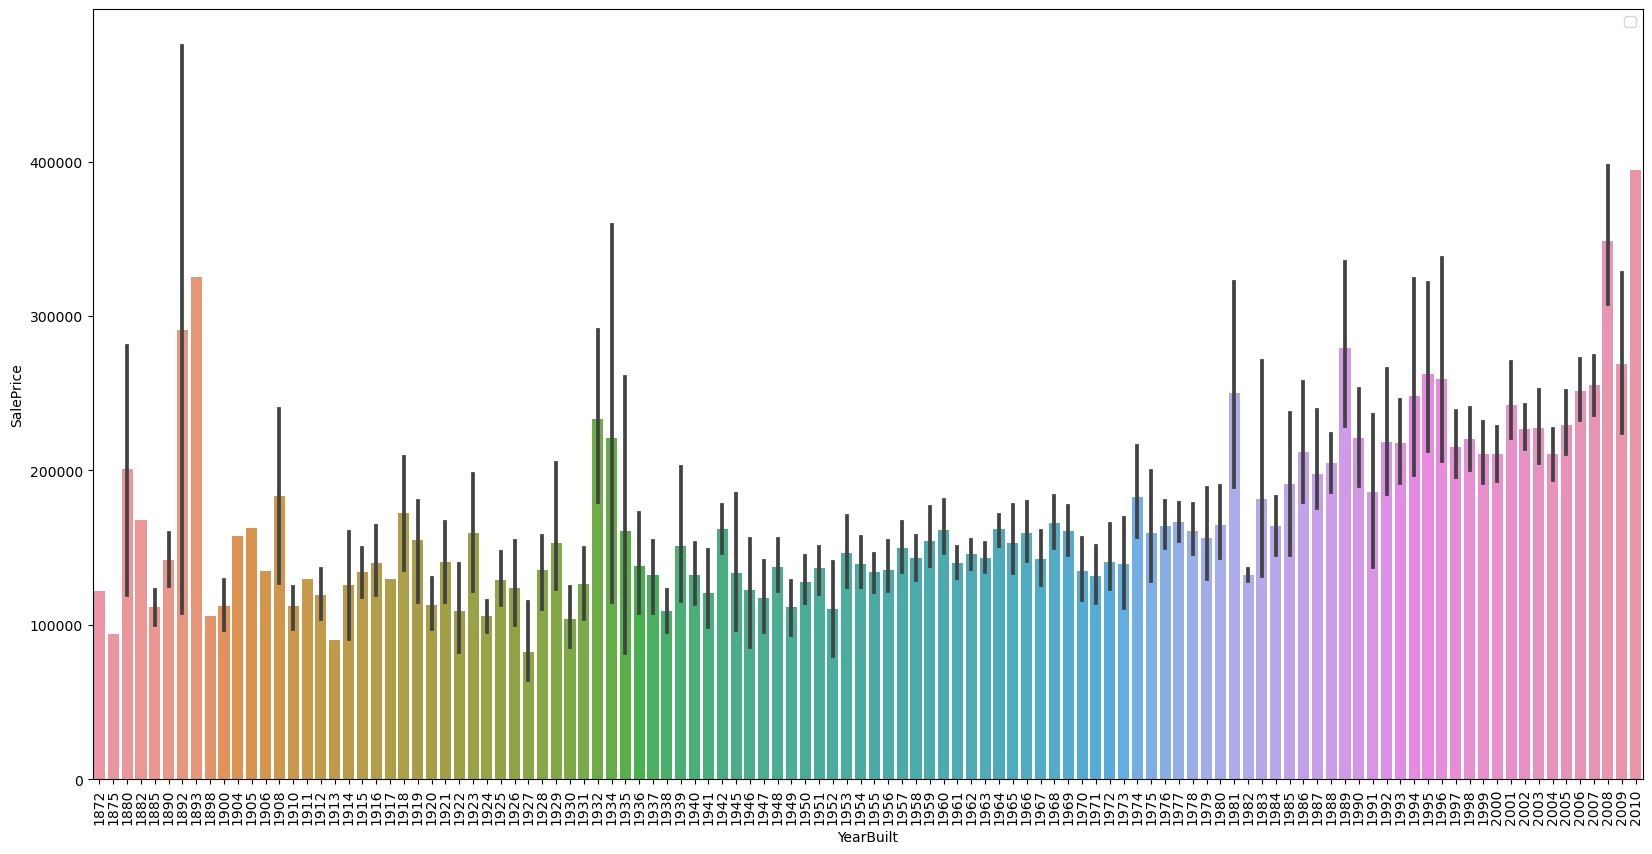

In [10]:
plt.figure(figsize=(20,10))
var =["YearBuilt","OverallQual"]
sns.barplot(x=train[var[0]],y=train["SalePrice"])
plt.xticks(rotation=90)
plt.legend()

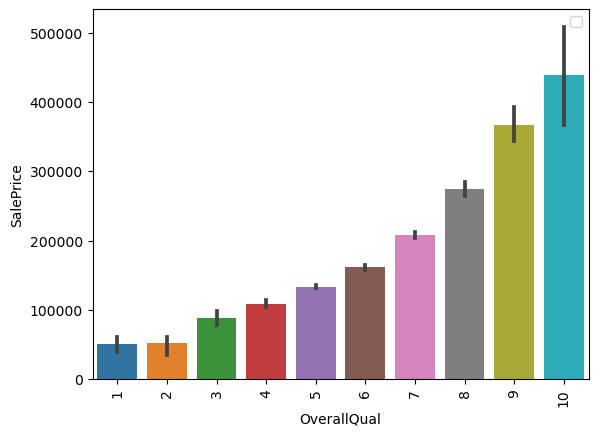

In [11]:
sns.barplot(x=train[var[1]],y=train["SalePrice"])
plt.xticks(rotation=90)
plt.legend()

# EDA

<Axes: >

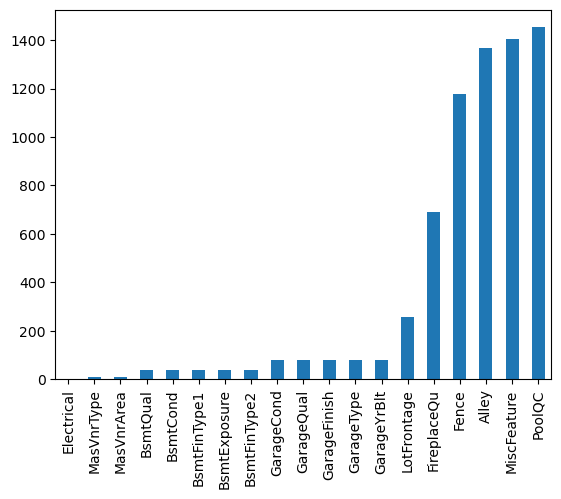

In [12]:
missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()

<Axes: >

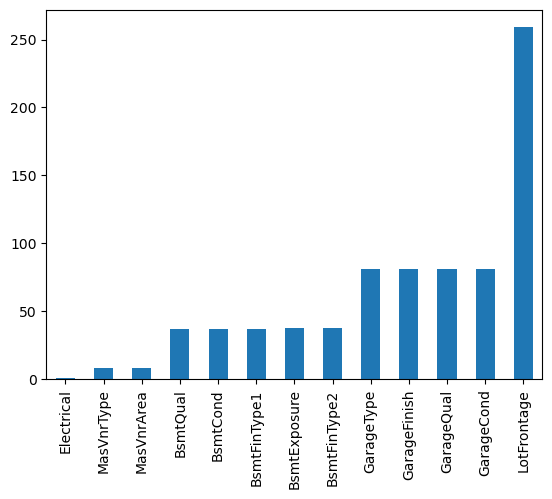

In [13]:
missing_percent = (train.isnull().sum() / len(train)) * 100

threshold = 20
columns_to_drop = missing_percent[missing_percent > threshold].index.tolist()
columns_to_drop.append("GarageYrBlt")
train = train.drop(columns=columns_to_drop)

columns_to_drop_dict = {'columns_to_drop': columns_to_drop}

remaining_missing = train.isnull().sum()
remaining_missing = remaining_missing[remaining_missing > 0]
remaining_missing.sort_values(inplace=True)
remaining_missing.plot.bar()

In [14]:
quantitative = [f for f in train.columns if train.dtypes[f] != 'object']
quantitative.remove('SalePrice')
quantitative.remove('Id')
qualitative = [f for f in train.columns if train.dtypes[f] == 'object']

/tmp/ipykernel_32/617968865.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=st.johnsonsu)
/tmp/ipykernel_32/617968865.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, kde=False, fit=st.norm)
/tmp/ipykernel_32/617968865.py:8: UserWarning: 

`distplot` is a deprecated f

<Axes: title={'center': 'Log Normal'}, xlabel='SalePrice'>

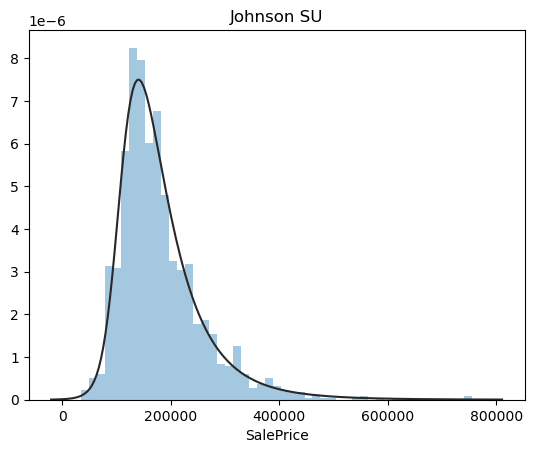

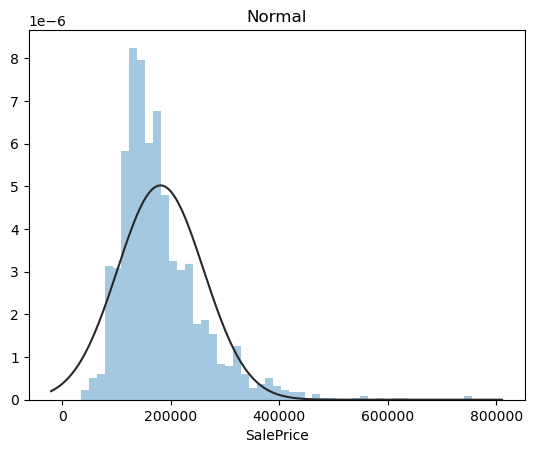

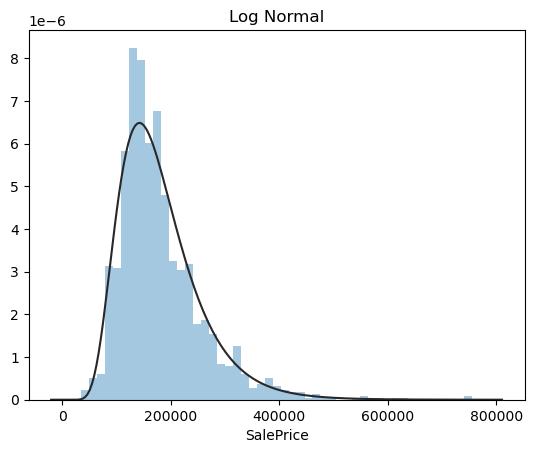

In [15]:
import scipy.stats as st
y = train['SalePrice']
plt.figure(1); plt.title('Johnson SU')
sns.distplot(y, kde=False, fit=st.johnsonsu)
plt.figure(2); plt.title('Normal')
sns.distplot(y, kde=False, fit=st.norm)
plt.figure(3); plt.title('Log Normal')
sns.distplot(y, kde=False, fit=st.lognorm)

<Axes: xlabel='SalePrice', ylabel='Count'>

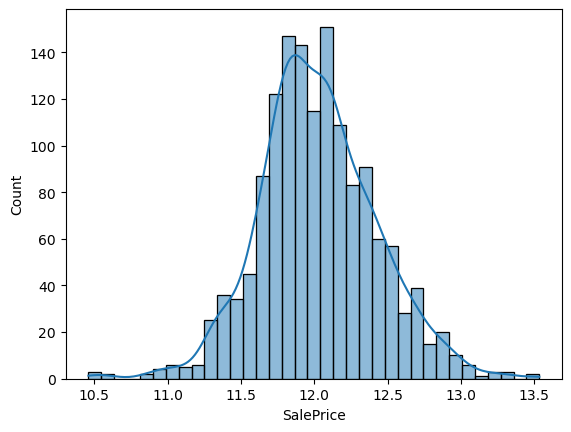

In [16]:
sns.histplot(np.log1p(train.SalePrice),kde=True)


In [17]:
train.SalePrice = np.log1p(train.SalePrice)
y = train.SalePrice

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  func(*plot_args, **plot_kwargs)
/opt/conda/lib/python3.10/site-packa

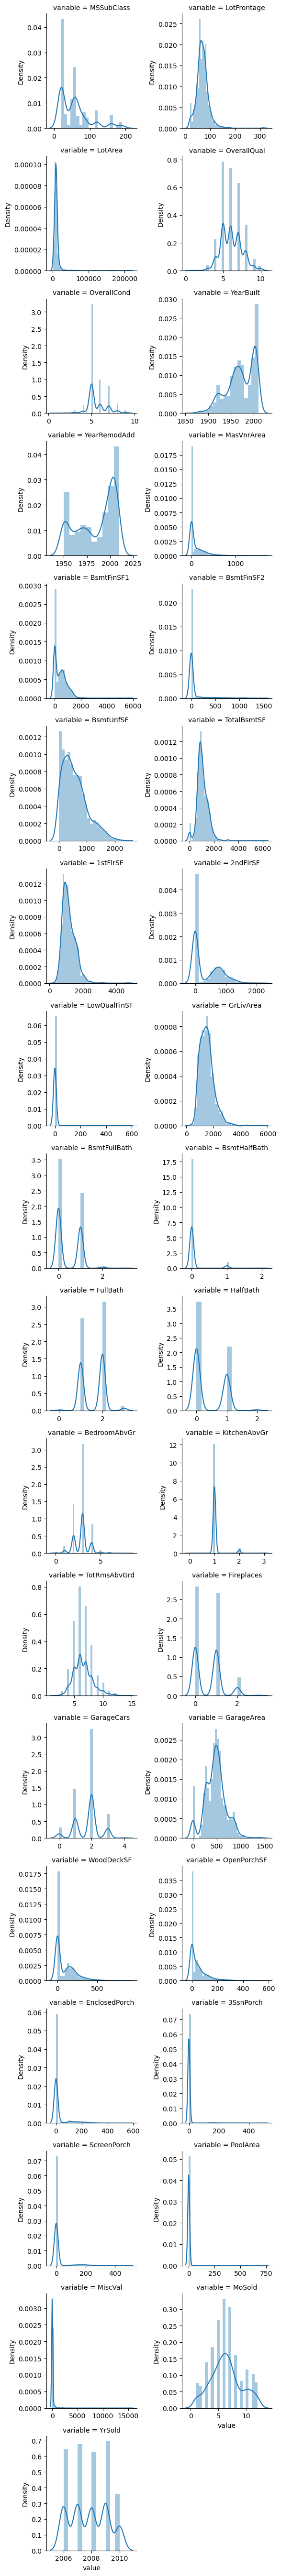

In [18]:
f = pd.melt(train, value_vars=quantitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(sns.distplot, "value")

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


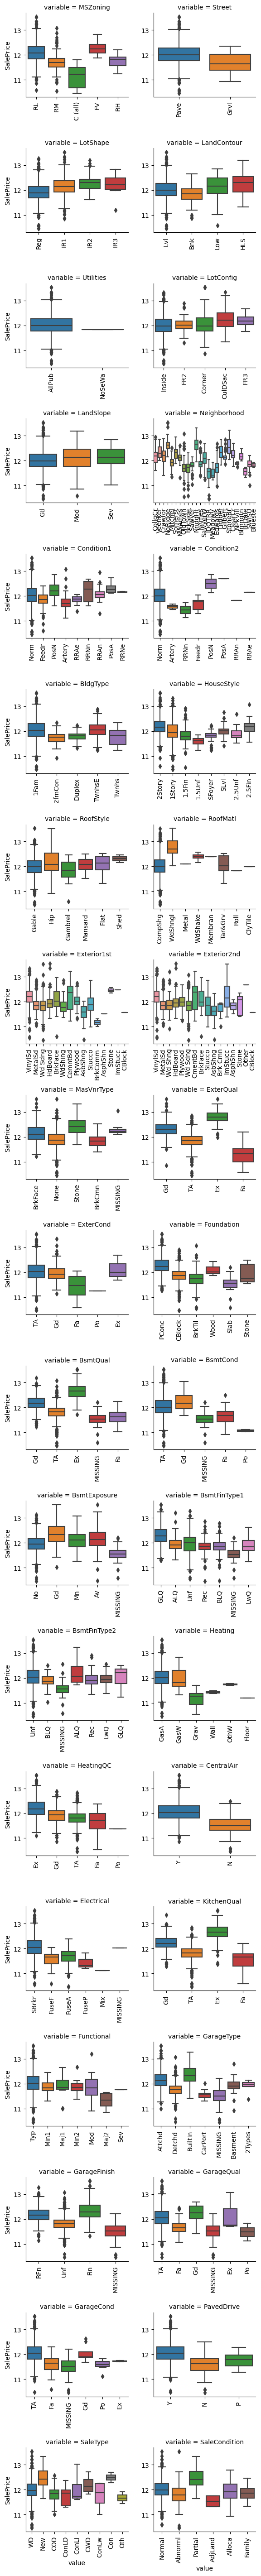

In [19]:
for c in qualitative:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=qualitative)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False)
g = g.map(boxplot, "value", "SalePrice")

In [20]:
train.loc[:, "BedroomAbvGr"] = train.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
train.loc[:, "BsmtExposure"] = train.loc[:, "BsmtExposure"].fillna("No")
train.loc[:, "BsmtFinType1"] = train.loc[:, "BsmtFinType1"].fillna("No")
train.loc[:, "BsmtFinType2"] = train.loc[:, "BsmtFinType2"].fillna("No")
train.loc[:, "BsmtFullBath"] = train.loc[:, "BsmtFullBath"].fillna(0)
train.loc[:, "BsmtHalfBath"] = train.loc[:, "BsmtHalfBath"].fillna(0)
train.loc[:, "BsmtUnfSF"] = train.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
train.loc[:, "CentralAir"] = train.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
train.loc[:, "Condition1"] = train.loc[:, "Condition1"].fillna("Norm")
train.loc[:, "Condition2"] = train.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
train.loc[:, "EnclosedPorch"] = train.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
train.loc[:, "ExterCond"] = train.loc[:, "ExterCond"].fillna("TA")
train.loc[:, "ExterQual"] = train.loc[:, "ExterQual"].fillna("TA")

train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
train.loc[:, "Functional"] = train.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
train.loc[:, "GarageType"] = train.loc[:, "GarageType"].fillna("No")
train.loc[:, "GarageFinish"] = train.loc[:, "GarageFinish"].fillna("No")
train.loc[:, "GarageQual"] = train.loc[:, "GarageQual"].fillna("No")
train.loc[:, "GarageCond"] = train.loc[:, "GarageCond"].fillna("No")
train.loc[:, "GarageArea"] = train.loc[:, "GarageArea"].fillna(0)
train.loc[:, "GarageCars"] = train.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
train.loc[:, "HalfBath"] = train.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
train.loc[:, "HeatingQC"] = train.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
train.loc[:, "KitchenAbvGr"] = train.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
train.loc[:, "KitchenQual"] = train.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
train.loc[:, "LotFrontage"] = train.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
train.loc[:, "LotShape"] = train.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
train.loc[:, "MasVnrType"] = train.loc[:, "MasVnrType"].fillna("None")
train.loc[:, "MasVnrArea"] = train.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
train.loc[:, "MiscVal"] = train.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
train.loc[:, "OpenPorchSF"] = train.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
train.loc[:, "PavedDrive"] = train.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
train.loc[:, "PoolArea"] = train.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
train.loc[:, "SaleCondition"] = train.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
train.loc[:, "ScreenPorch"] = train.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
train.loc[:, "TotRmsAbvGrd"] = train.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
train.loc[:, "Utilities"] = train.loc[:, "Utilities"].fillna("AllPub")

train.loc[:, "WoodDeckSF"] = train.loc[:, "WoodDeckSF"].fillna(0)

/tmp/ipykernel_32/1266000593.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:, "BsmtQual"] = train.loc[:, "BsmtQual"].fillna("No")
/tmp/ipykernel_32/1266000593.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train.loc[:, "BsmtCond"] = train.loc[:, "BsmtCond"].fillna("No")
/tmp/ipykernel_32/1266000593.py:5: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, i

In [21]:
# train = train.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
#                                        50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
#                                        80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
#                                        150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"},
#                        "MoSold" : {1 : "Jan", 2 : "Feb", 3 : "Mar", 4 : "Apr", 5 : "May", 6 : "Jun",
#                                    7 : "Jul", 8 : "Aug", 9 : "Sep", 10 : "Oct", 11 : "Nov", 12 : "Dec"}
#                       })

In [22]:
# # Encode some categorical features as ordered numbers when there is information in the order
# train = train.replace({
#                        "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
#                        "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
#                                          "ALQ" : 5, "GLQ" : 6},
#                        "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
#                                          "ALQ" : 5, "GLQ" : 6},
#                        "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
#                        "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
#                        "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
#                        "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
#                                        "Min2" : 6, "Min1" : 7, "Typ" : 8},
#                        "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
#                        "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
#                        "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
#                        "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
#                        "Street" : {"Grvl" : 1, "Pave" : 2},
#                        "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4},
#                         "LandContour" : {"Lvl":1,"Bnk":2,"HLS":3,"Low":4},
#                         "LotConfig" : {"Inside":1,"Corner":2,"CulDSac":3,"FR2":4,"FR3":5},
#                         "Neighborhood" :{'NAmes':1, 'CollgCr':2, 'OldTown':3, 'Edwards':4, 'Somerst':5,
#                   'Gilbert':6, 'NridgHt':7, 'Sawyer':8, 'NWAmes':9, 'SawyerW':10,
#                   'BrkSide':11, 'Crawfor':12, 'Mitchel':13, 'NoRidge':14, 'Timber':15,
#                   'IDOTRR':16, 'ClearCr':17, 'StoneBr':18, 'SWISU':19, 'Blmngtn':20,
#                   'MeadowV':21, 'BrDale':22, 'Veenker':23, 'NPkVill':24, 'Blueste':25},
#                     'Condition1':{'Norm':1, 'Feedr':2, 'Artery':3, 'RRAn':4, 'PosN':5, 'RRAe':6, 'PosA':7,
#                   'RRNn':8, 'RRNe':9},
#     'Condition2':{'Norm':1, 'Feedr':2, 'Artery':3, 'RRAn':4, 'PosN':5, 'RRAe':6, 'PosA':7,
#                   'RRNn':8, 'RRNe':9},
#     "BldgType":{'1Fam':1, 'TwnhsE':2, 'Duplex':3, 'Twnhs':4, '2fmCon':5},
#     "HouseStyle":{'1Story':1, '2Story':2, '1.5Fin':3, 'SLvl':4, 'SFoyer':5, '1.5Unf':6,
#                   '2.5Unf':7, '2.5Fin':8}
# })

In [23]:
train["RoofStyle"].value_counts().index

CategoricalIndex(['Gable', 'Hip', 'Flat', 'Gambrel', 'Mansard', 'Shed'], categories=['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed'], ordered=False, dtype='category')

In [24]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
for i in qualitative:
    train[i] = label_encoder.fit_transform(train[i])
    train[i]=pd.to_numeric(train[i])

In [25]:
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
print(corr.SalePrice)

Find most important features relative to target
SalePrice      1.000000
OverallQual    0.817185
GrLivArea      0.700927
GarageCars     0.680625
GarageArea     0.650888
                 ...   
HeatingQC     -0.425906
GarageType    -0.503129
KitchenQual   -0.534387
BsmtQual      -0.576969
ExterQual     -0.582164
Name: SalePrice, Length: 75, dtype: float64


In [26]:
train.pop("Id")

0          1
1          2
2          3
3          4
4          5
        ... 
1455    1456
1456    1457
1457    1458
1458    1459
1459    1460
Name: Id, Length: 1460, dtype: int64

In [27]:
for i in quantitative:
    train[i]=np.log1p(train[i])

In [28]:
train.pop("SalePrice")
x=train

In [29]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (1022, 73)
X_test : (438, 73)
y_train : (1022,)
y_test : (438,)


In [30]:
from sklearn.preprocessing import StandardScaler,MinMaxScaler

In [34]:
minmax=MinMaxScaler()
for i in qualitative:
    X_train[i] = minmax.fit_transform(X_train[i].values.reshape(-1, 1))
    X_test[i] = minmax.transform(X_test[i].values.reshape(-1, 1))

In [36]:
stdSc = StandardScaler()
for i in quantitative:
    X_train[i]= stdSc.fit_transform(X_train[i].values.reshape(-1,1))
    X_test[i] = stdSc.transform(X_test[i].values.reshape(-1,1))

In [37]:
from sklearn.linear_model import LinearRegression 

RMSE on Training set : 0.1210846826953827
RMSE on Test set : 0.16085626474890047


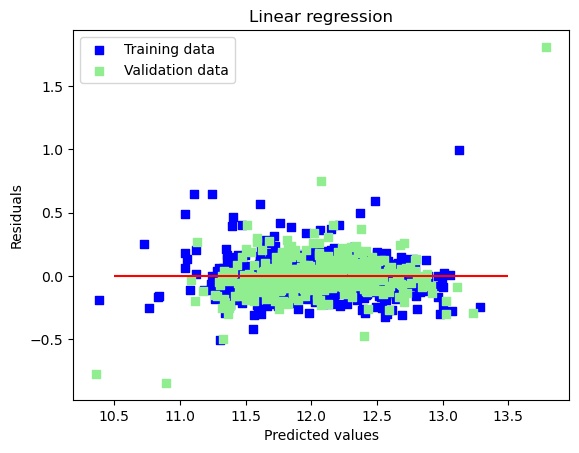

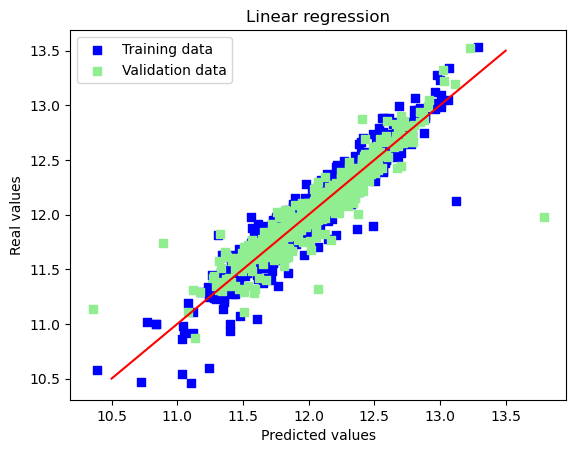

In [38]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)
# Look at predictions on training and validation set
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
print("RMSE on Training set :", np.sqrt(mean_squared_error(y_train_pred,y_train)))
print("RMSE on Test set :", np.sqrt(mean_squared_error(y_test_pred,y_test)))

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

Best alpha : 10.0
Try again for more precision with alphas centered around 10.0
Best alpha : 12.5
RMSE on Training set : 0.12419510391960555
RMSE on Test set : 0.14325992832554624


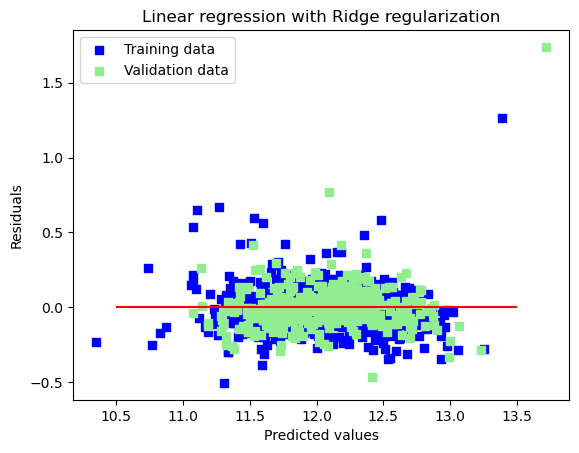

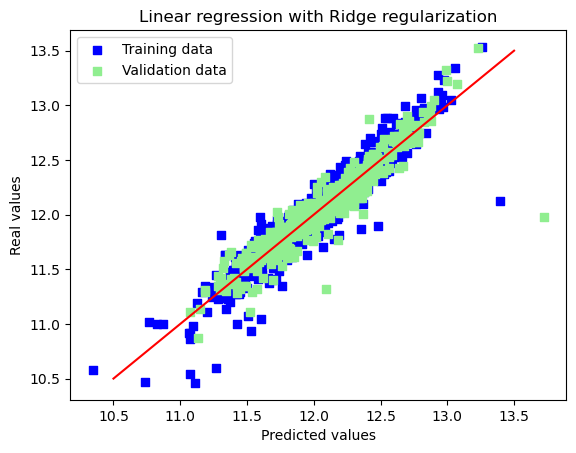

Ridge picked 73 features and eliminated the other 0 features


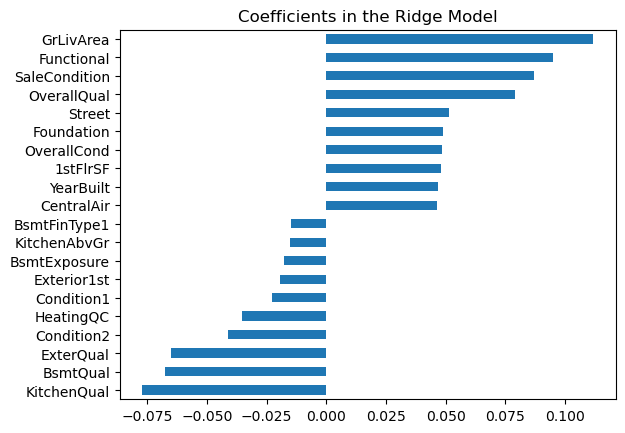

In [39]:
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

print("RMSE on Training set :", np.sqrt(mean_squared_error(y_train_rdg,y_train)))
print("RMSE on Test set :", np.sqrt(mean_squared_error(y_test_rdg,y_test)))
# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()

Best alpha : 0.001
Try again for more precision with alphas centered around 0.001
Best alpha : 0.00115
RMSE on Training set : 0.1263698355696879
RMSE on Test set : 0.14256686451827355


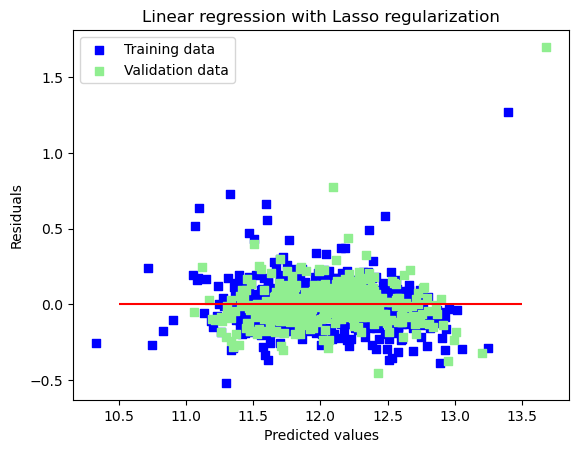

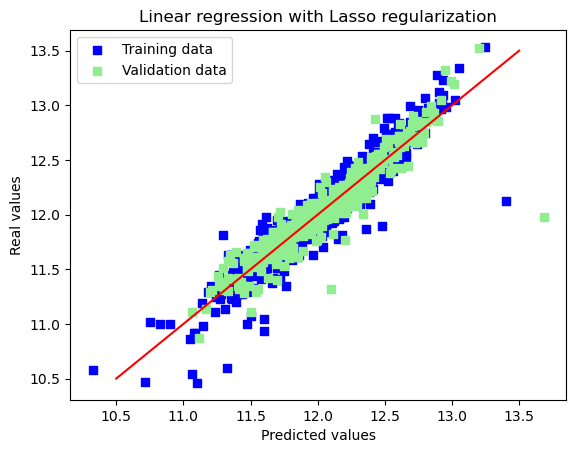

Lasso picked 42 features and eliminated the other 31 features


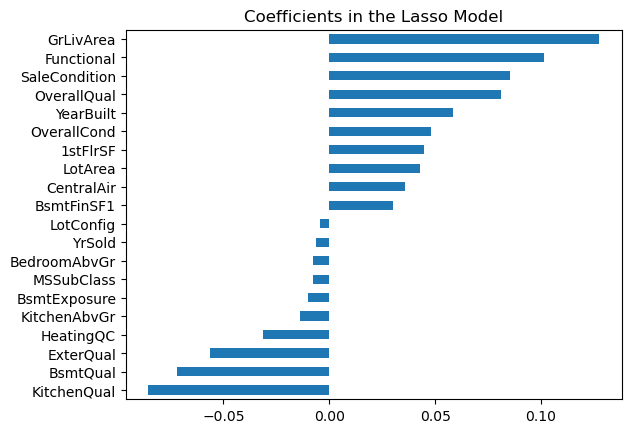

In [40]:
from sklearn.linear_model import LassoCV
lasso = LassoCV(alphas = [0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 
                          0.3, 0.6, 1], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
lasso = LassoCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, 
                          alpha * .85, alpha * .9, alpha * .95, alpha, alpha * 1.05, 
                          alpha * 1.1, alpha * 1.15, alpha * 1.25, alpha * 1.3, alpha * 1.35, 
                          alpha * 1.4], 
                max_iter = 50000, cv = 10)
lasso.fit(X_train, y_train)
alpha = lasso.alpha_
print("Best alpha :", alpha)

y_train_las = lasso.predict(X_train)
y_test_las = lasso.predict(X_test)

print("RMSE on Training set :", np.sqrt(mean_squared_error(y_train_las,y_train)))
print("RMSE on Test set :", np.sqrt(mean_squared_error(y_test_las,y_test)))
# Plot residuals
plt.scatter(y_train_las, y_train_las - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test_las - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_las, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_las, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Lasso regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(lasso.coef_, index = X_train.columns)
print("Lasso picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
plt.show()

Best l1_ratio: 1.0
Best alpha: 0.001
Try again for more precision with l1_ratio centered around 1.0
Best l1_ratio: 1.0
Best alpha: 0.001
Now try again for more precision on alpha, with l1_ratio fixed at 1.0 and alpha centered around 0.001
Best l1_ratio: 1.0
Best alpha: 0.00115
RMSE on Training set: 0.1263698355696879
RMSE on Test set: 0.14256686451827355


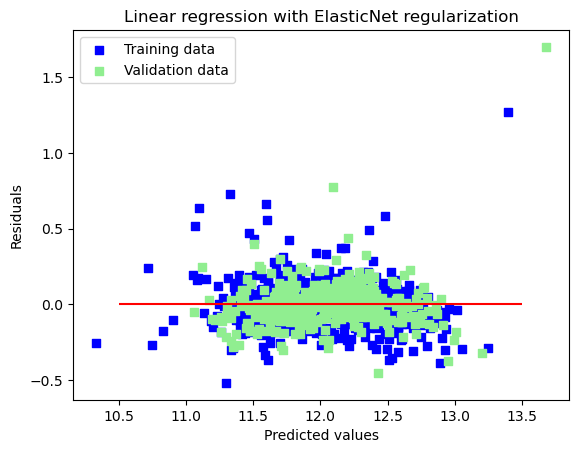

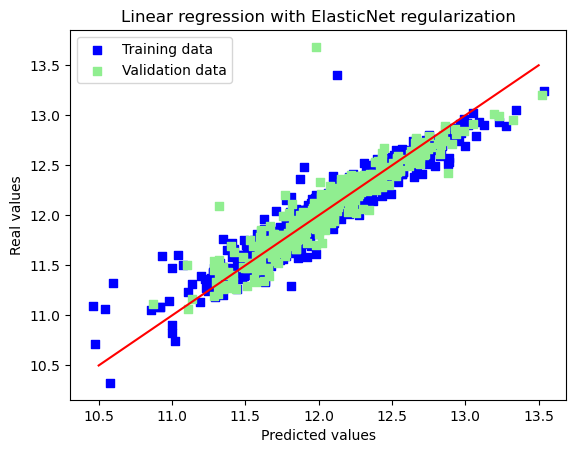

ElasticNet picked 42 features and eliminated the other 31 features


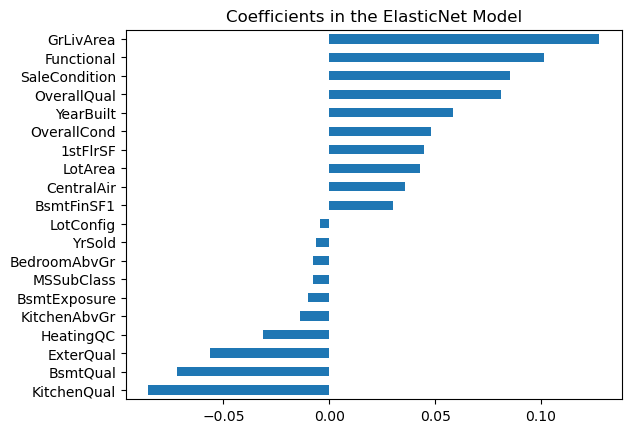

In [41]:
from sklearn.linear_model import ElasticNetCV

# Assuming X_train, X_test, y_train, and y_test are defined

elasticNet = ElasticNetCV(l1_ratio=[0.1, 0.3, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.95, 1],
                          alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006,
                                  0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
                          max_iter=50000, cv=10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio:", ratio)
print("Best alpha:", alpha)

print("Try again for more precision with l1_ratio centered around " + str(ratio))
elasticNet = ElasticNetCV(l1_ratio=[max(0, ratio * .85), max(0, ratio * .9), max(0, ratio * .95), ratio,
                                    min(1, ratio * 1.05), min(1, ratio * 1.1), min(1, ratio * 1.15)],
                          alphas=[0.0001, 0.0003, 0.0006, 0.001, 0.003, 0.006, 0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6],
                          max_iter=50000, cv=10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio:", ratio)
print("Best alpha:", alpha)

print("Now try again for more precision on alpha, with l1_ratio fixed at " + str(ratio) +
      " and alpha centered around " + str(alpha))
elasticNet = ElasticNetCV(l1_ratio=ratio,
                          alphas=[max(0, alpha * .6), max(0, alpha * .65), max(0, alpha * .7), max(0, alpha * .75),
                                  max(0, alpha * .8), max(0, alpha * .85), max(0, alpha * .9),
                                  max(0, alpha * .95), alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                                  alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4],
                          max_iter=50000, cv=10)
elasticNet.fit(X_train, y_train)
alpha = elasticNet.alpha_
ratio = elasticNet.l1_ratio_
print("Best l1_ratio:", ratio)
print("Best alpha:", alpha)

y_train_ela = elasticNet.predict(X_train)
y_test_ela = elasticNet.predict(X_test)

print("RMSE on Training set:", np.sqrt(mean_squared_error(y_train_ela, y_train)))
print("RMSE on Test set:", np.sqrt(mean_squared_error(y_test_ela, y_test)))

# Plot residuals
plt.scatter(y_train_ela, y_train_ela - y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_ela, y_test_ela - y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train, y_train_ela, c="blue", marker="s", label="Training data")
plt.scatter(y_test, y_test_ela, c="lightgreen", marker="s", label="Validation data")
plt.title("Linear regression with ElasticNet regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()

# Plot important coefficients
coefs = pd.Series(elasticNet.coef_, index=X_train.columns)
print("ElasticNet picked " + str(sum(coefs != 0)) + " features and eliminated the other " + str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                       coefs.sort_values().tail(10)])
imp_coefs.plot(kind="barh")
plt.title("Coefficients in the ElasticNet Model")
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:342: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RMSE on Training set: 0.3442127770584205
RMSE on Test set: 0.3165240097602417


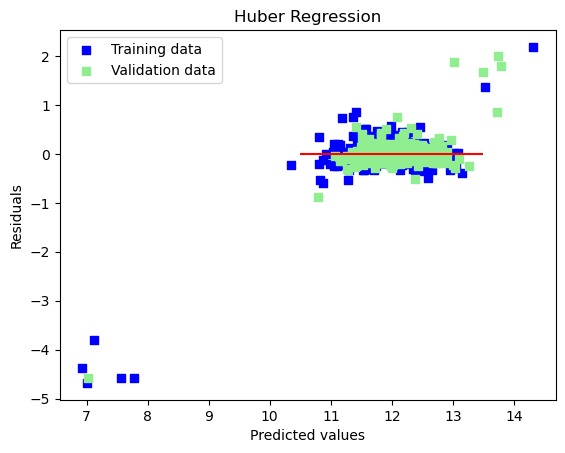

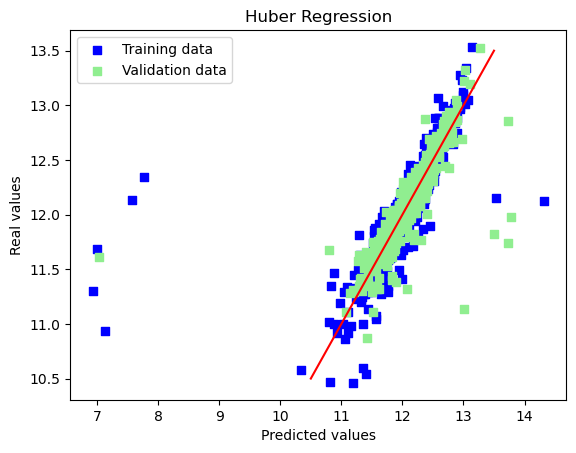

In [69]:
from sklearn.linear_model import HuberRegressor
huber = HuberRegressor(epsilon=1.35)

# Fit the model with cross-validation to find the best epsilon
huber.fit(X_train, y_train)


# Predictions on training and testing sets
y_train_huber = huber.predict(X_train)
y_test_huber = huber.predict(X_test)

# Print RMSE on training and testing sets
print("RMSE on Training set:", np.sqrt(mean_squared_error(y_train_huber, y_train)))
print("RMSE on Test set:", np.sqrt(mean_squared_error(y_test_huber, y_test)))

# Plot residuals
plt.scatter(y_train_huber, y_train_huber - y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_huber, y_test_huber - y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Huber Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_huber, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_huber, y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Huber Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()

In [42]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

In [78]:
columns_to_drop

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'GarageYrBlt']

In [43]:
test = test.drop(columns=columns_to_drop)


In [44]:
test.loc[:, "BedroomAbvGr"] = test.loc[:, "BedroomAbvGr"].fillna(0)
# BsmtQual etc : data description says NA for basement features is "no basement"
test.loc[:, "BsmtQual"] = test.loc[:, "BsmtQual"].fillna("No")
test.loc[:, "BsmtCond"] = test.loc[:, "BsmtCond"].fillna("No")
test.loc[:, "BsmtExposure"] = test.loc[:, "BsmtExposure"].fillna("No")
test.loc[:, "BsmtFinType1"] = test.loc[:, "BsmtFinType1"].fillna("No")
test.loc[:, "BsmtFinType2"] = test.loc[:, "BsmtFinType2"].fillna("No")
test.loc[:, "BsmtFullBath"] = test.loc[:, "BsmtFullBath"].fillna(0)
test.loc[:, "BsmtHalfBath"] = test.loc[:, "BsmtHalfBath"].fillna(0)
test.loc[:, "BsmtUnfSF"] = test.loc[:, "BsmtUnfSF"].fillna(0)
# CentralAir : NA most likely means No
test.loc[:, "CentralAir"] = test.loc[:, "CentralAir"].fillna("N")
# Condition : NA most likely means Normal
test.loc[:, "Condition1"] = test.loc[:, "Condition1"].fillna("Norm")
test.loc[:, "Condition2"] = test.loc[:, "Condition2"].fillna("Norm")
# EnclosedPorch : NA most likely means no enclosed porch
test.loc[:, "EnclosedPorch"] = test.loc[:, "EnclosedPorch"].fillna(0)
# External stuff : NA most likely means average
test.loc[:, "ExterCond"] = test.loc[:, "ExterCond"].fillna("TA")
test.loc[:, "ExterQual"] = test.loc[:, "ExterQual"].fillna("TA")

train.loc[:, "Fireplaces"] = train.loc[:, "Fireplaces"].fillna(0)
# Functional : data description says NA means typical
test.loc[:, "Functional"] = test.loc[:, "Functional"].fillna("Typ")
# GarageType etc : data description says NA for garage features is "no garage"
test.loc[:, "GarageType"] = test.loc[:, "GarageType"].fillna("No")
test.loc[:, "GarageFinish"] = test.loc[:, "GarageFinish"].fillna("No")
test.loc[:, "GarageQual"] = test.loc[:, "GarageQual"].fillna("No")
test.loc[:, "GarageCond"] = test.loc[:, "GarageCond"].fillna("No")
test.loc[:, "GarageArea"] = test.loc[:, "GarageArea"].fillna(0)
test.loc[:, "GarageCars"] = test.loc[:, "GarageCars"].fillna(0)
# HalfBath : NA most likely means no half baths above grade
test.loc[:, "HalfBath"] = test.loc[:, "HalfBath"].fillna(0)
# HeatingQC : NA most likely means typical
test.loc[:, "HeatingQC"] = test.loc[:, "HeatingQC"].fillna("TA")
# KitchenAbvGr : NA most likely means 0
test.loc[:, "KitchenAbvGr"] = test.loc[:, "KitchenAbvGr"].fillna(0)
# KitchenQual : NA most likely means typical
test.loc[:, "KitchenQual"] = test.loc[:, "KitchenQual"].fillna("TA")
# LotFrontage : NA most likely means no lot frontage
test.loc[:, "LotFrontage"] = test.loc[:, "LotFrontage"].fillna(0)
# LotShape : NA most likely means regular
test.loc[:, "LotShape"] = test.loc[:, "LotShape"].fillna("Reg")
# MasVnrType : NA most likely means no veneer
test.loc[:, "MasVnrType"] = test.loc[:, "MasVnrType"].fillna("None")
test.loc[:, "MasVnrArea"] = test.loc[:, "MasVnrArea"].fillna(0)
# MiscFeature : data description says NA means "no misc feature"
test.loc[:, "MiscVal"] = test.loc[:, "MiscVal"].fillna(0)
# OpenPorchSF : NA most likely means no open porch
test.loc[:, "OpenPorchSF"] = test.loc[:, "OpenPorchSF"].fillna(0)
# PavedDrive : NA most likely means not paved
test.loc[:, "PavedDrive"] = test.loc[:, "PavedDrive"].fillna("N")
# PoolQC : data description says NA means "no pool"
test.loc[:, "PoolArea"] = test.loc[:, "PoolArea"].fillna(0)
# SaleCondition : NA most likely means normal sale
test.loc[:, "SaleCondition"] = test.loc[:, "SaleCondition"].fillna("Normal")
# ScreenPorch : NA most likely means no screen porch
test.loc[:, "ScreenPorch"] = test.loc[:, "ScreenPorch"].fillna(0)
# TotRmsAbvGrd : NA most likely means 0
test.loc[:, "TotRmsAbvGrd"] = test.loc[:, "TotRmsAbvGrd"].fillna(0)
# Utilities : NA most likely means all public utilities
test.loc[:, "Utilities"] = test.loc[:, "Utilities"].fillna("AllPub")

test.loc[:, "WoodDeckSF"] = test.loc[:, "WoodDeckSF"].fillna(0)

In [45]:
from sklearn.preprocessing import LabelEncoder
label_encoder=LabelEncoder()
for i in qualitative:
    test[i] = label_encoder.fit_transform(test[i])
    test[i]=pd.to_numeric(test[i])

In [46]:
Id=test.pop("Id")

In [47]:
# Assuming 'test' is your DataFrame
columns_to_fill = ['BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF']

# Fill null values with 0 in the specified columns
test[columns_to_fill] = test[columns_to_fill].fillna(0)


In [48]:
col=test.isnull().sum()[test.isnull().sum()>0]
col

Series([], dtype: int64)

In [49]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 73 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1459 non-null   int64  
 1   MSZoning       1459 non-null   int64  
 2   LotFrontage    1459 non-null   float64
 3   LotArea        1459 non-null   int64  
 4   Street         1459 non-null   int64  
 5   LotShape       1459 non-null   int64  
 6   LandContour    1459 non-null   int64  
 7   Utilities      1459 non-null   int64  
 8   LotConfig      1459 non-null   int64  
 9   LandSlope      1459 non-null   int64  
 10  Neighborhood   1459 non-null   int64  
 11  Condition1     1459 non-null   int64  
 12  Condition2     1459 non-null   int64  
 13  BldgType       1459 non-null   int64  
 14  HouseStyle     1459 non-null   int64  
 15  OverallQual    1459 non-null   int64  
 16  OverallCond    1459 non-null   int64  
 17  YearBuilt      1459 non-null   int64  
 18  YearRemo

<Axes: xlabel='linear', ylabel='lasso'>

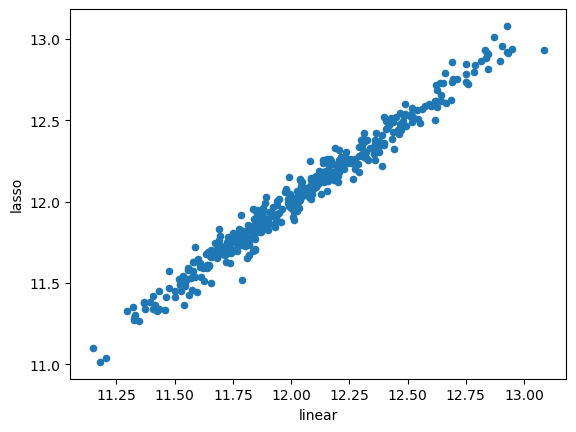

In [59]:
predictions = pd.DataFrame({"linear":y_pred_rf, "lasso":y_pred_gb})
predictions.plot(x = "linear", y = "lasso", kind = "scatter")

RMSE on Training set: 0.07503838777668405
RMSE on Test set: 0.12677626476138085


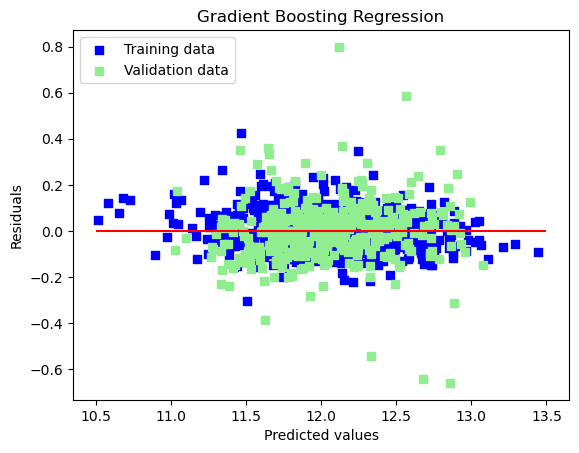

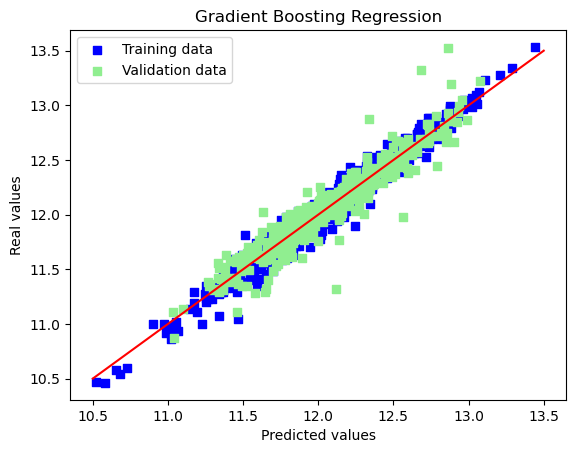

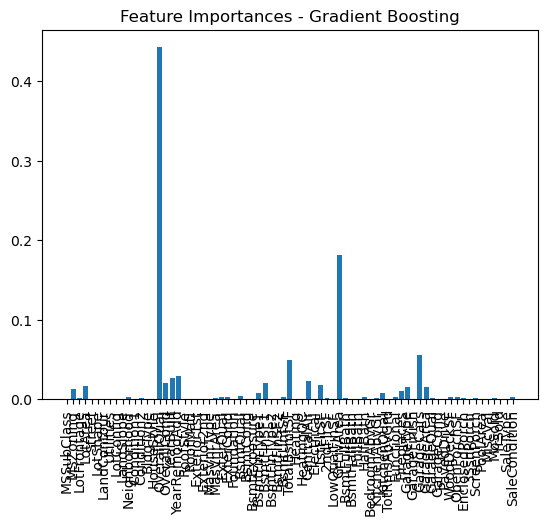

In [72]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor()

# Fit the model
gb.fit(X_train, y_train)

# Predictions on training and testing sets
y_train_gb = gb.predict(X_train)
y_test_gb = gb.predict(X_test)

# Print RMSE on training and testing sets
print("RMSE on Training set:", np.sqrt(mean_squared_error(y_train_gb, y_train)))
print("RMSE on Test set:", np.sqrt(mean_squared_error(y_test_gb, y_test)))

# Plot residuals
plt.scatter(y_train_gb, y_train_gb - y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_gb, y_test_gb - y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Gradient Boosting Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_gb, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_gb, y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Gradient Boosting Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()

# Plot feature importances
plt.bar(range(len(gb.feature_importances_)), gb.feature_importances_)
plt.xticks(range(len(gb.feature_importances_)), X_train.columns, rotation='vertical')
plt.title("Feature Importances - Gradient Boosting")
plt.show()

RMSE on Training set: 0.005720481571461601
RMSE on Test set: 0.1347090158960395


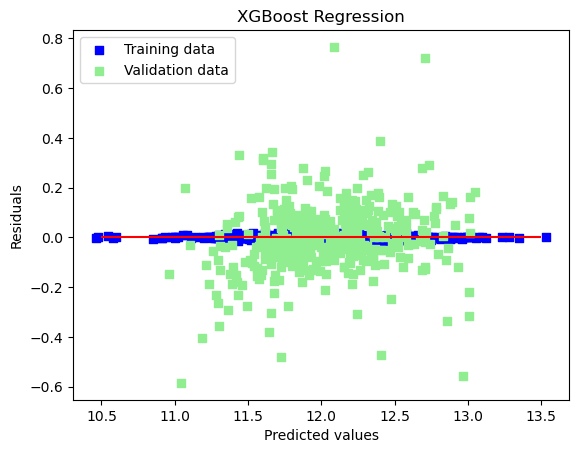

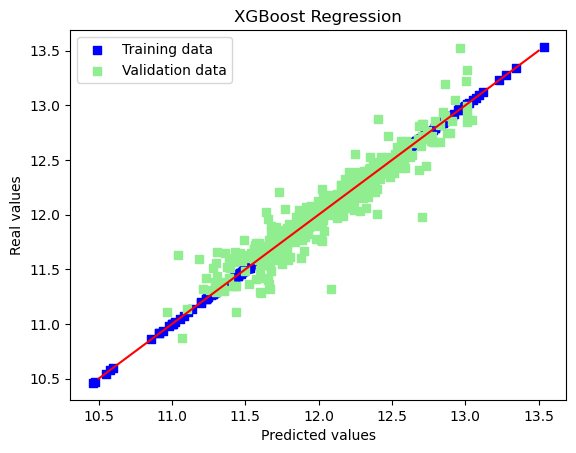

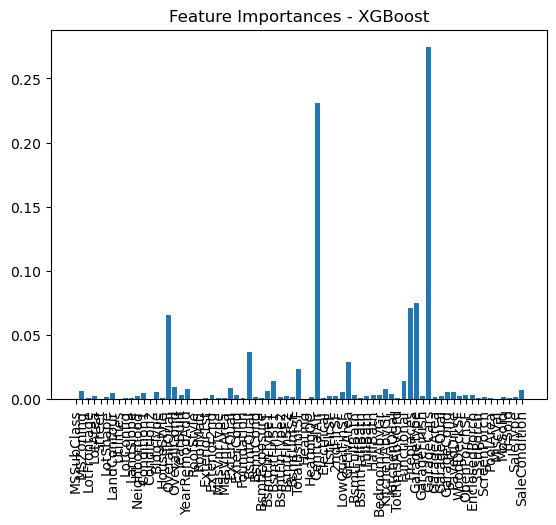

In [70]:
from xgboost import XGBRegressor
xgb = XGBRegressor()


# Fit the model
xgb.fit(X_train, y_train)

# Predictions on training and testing sets
y_train_xgb = xgb.predict(X_train)
y_test_xgb = xgb.predict(X_test)

# Print RMSE on training and testing sets
print("RMSE on Training set:", np.sqrt(mean_squared_error(y_train_xgb, y_train)))
print("RMSE on Test set:", np.sqrt(mean_squared_error(y_test_xgb, y_test)))

# Plot residuals
plt.scatter(y_train_xgb, y_train_xgb - y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_xgb, y_test_xgb - y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("XGBoost Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_xgb, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_xgb, y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("XGBoost Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()

# Plot feature importances
plt.bar(range(len(xgb.feature_importances_)), xgb.feature_importances_)
plt.xticks(range(len(xgb.feature_importances_)), X_train.columns, rotation='vertical')
plt.title("Feature Importances - XGBoost")
plt.show()

RMSE on Training set: 0.05550714283899245
RMSE on Test set: 0.13041864413621443


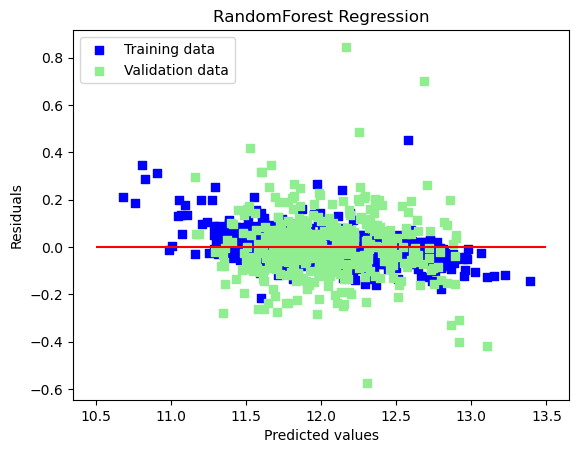

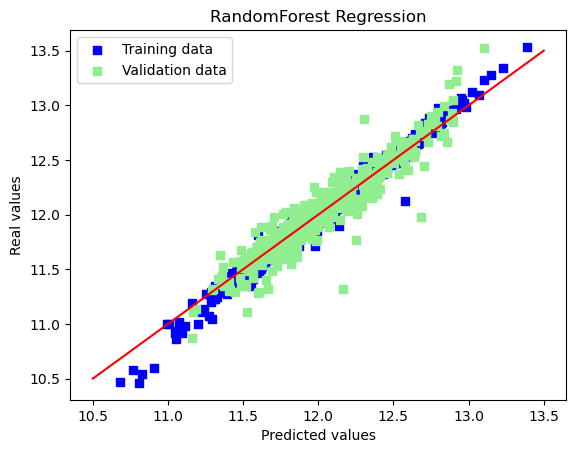

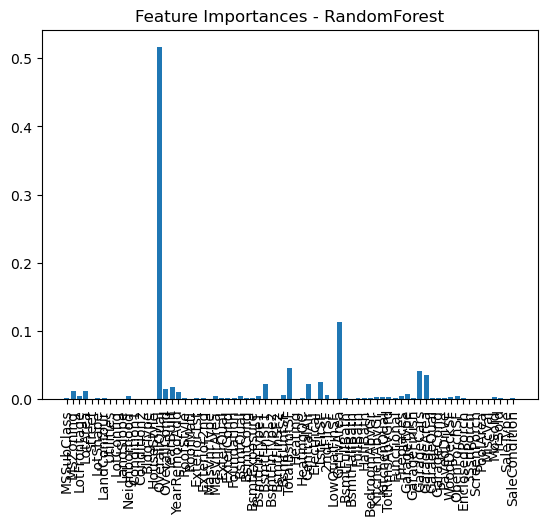

In [71]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor()

# Fit the model
rf.fit(X_train, y_train)

# Predictions on training and testing sets
y_train_rf = rf.predict(X_train)
y_test_rf = rf.predict(X_test)

# Print RMSE on training and testing sets
print("RMSE on Training set:", np.sqrt(mean_squared_error(y_train_rf, y_train)))
print("RMSE on Test set:", np.sqrt(mean_squared_error(y_test_rf, y_test)))

# Plot residuals
plt.scatter(y_train_rf, y_train_rf - y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_rf, y_test_rf - y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("RandomForest Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_rf, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_rf, y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("RandomForest Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()

# Plot feature importances
plt.bar(range(len(rf.feature_importances_)), rf.feature_importances_)
plt.xticks(range(len(rf.feature_importances_)), X_train.columns, rotation='vertical')
plt.title("Feature Importances - RandomForest")
plt.show()

Learning rate set to 0.041084
0:	learn: 0.3908603	total: 65ms	remaining: 1m 4s
1:	learn: 0.3814388	total: 68.4ms	remaining: 34.1s
2:	learn: 0.3722640	total: 72ms	remaining: 23.9s
3:	learn: 0.3632436	total: 75.2ms	remaining: 18.7s
4:	learn: 0.3546868	total: 78.5ms	remaining: 15.6s
5:	learn: 0.3467826	total: 81.9ms	remaining: 13.6s
6:	learn: 0.3382981	total: 85.8ms	remaining: 12.2s
7:	learn: 0.3307589	total: 89.2ms	remaining: 11.1s
8:	learn: 0.3227950	total: 94.2ms	remaining: 10.4s
9:	learn: 0.3153436	total: 98.7ms	remaining: 9.77s
10:	learn: 0.3090252	total: 103ms	remaining: 9.23s
11:	learn: 0.3023338	total: 107ms	remaining: 8.82s
12:	learn: 0.2958315	total: 112ms	remaining: 8.49s
13:	learn: 0.2890496	total: 116ms	remaining: 8.15s
14:	learn: 0.2832341	total: 119ms	remaining: 7.82s
15:	learn: 0.2777148	total: 123ms	remaining: 7.55s
16:	learn: 0.2718562	total: 126ms	remaining: 7.29s
17:	learn: 0.2665135	total: 129ms	remaining: 7.06s
18:	learn: 0.2617905	total: 133ms	remaining: 6.86s
19:	l

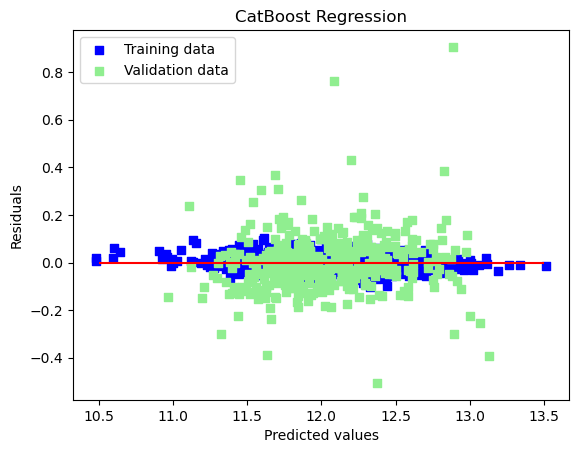

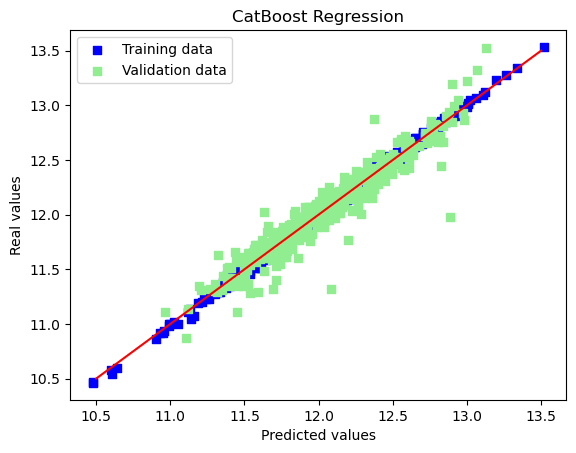

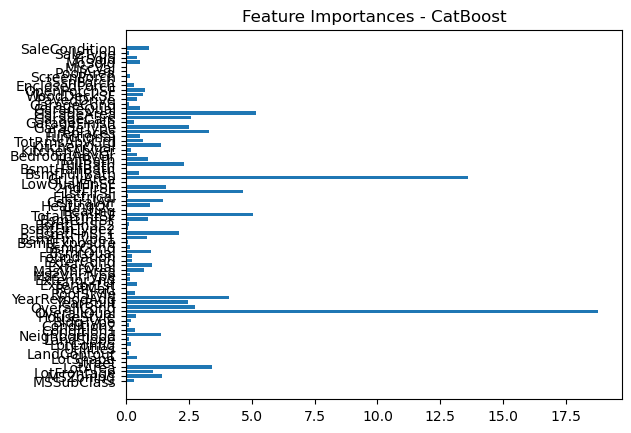

In [73]:
from catboost import CatBoostRegressor
catboost = CatBoostRegressor()

# Fit the model
catboost.fit(X_train, y_train)

# Predictions on training and testing sets
y_train_catboost = catboost.predict(X_train)
y_test_catboost = catboost.predict(X_test)

# Print RMSE on training and testing sets
print("RMSE on Training set:", np.sqrt(mean_squared_error(y_train_catboost, y_train)))
print("RMSE on Test set:", np.sqrt(mean_squared_error(y_test_catboost, y_test)))

# Plot residuals
plt.scatter(y_train_catboost, y_train_catboost - y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_catboost, y_test_catboost - y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("CatBoost Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_catboost, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_catboost, y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("CatBoost Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()

# Feature importances are available in catboost as well, similar to XGBoost
feature_importance = catboost.get_feature_importance()
feature_names = X_train.columns
plt.barh(feature_names, feature_importance)
plt.title("Feature Importances - CatBoost")
plt.show()

RMSE on Training set: 0.42508130465152844
RMSE on Test set: 0.5007360155928529


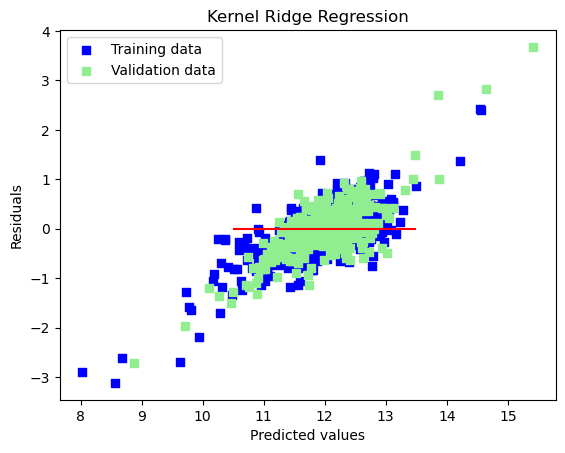

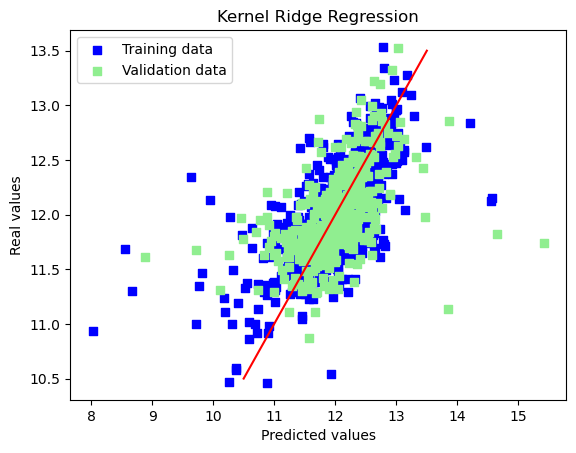

In [77]:
from sklearn.kernel_ridge import KernelRidge
kernel_ridge = KernelRidge()

# Fit the model
kernel_ridge.fit(X_train, y_train)

# Predictions on training and testing sets
y_train_kernel_ridge = kernel_ridge.predict(X_train)
y_test_kernel_ridge = kernel_ridge.predict(X_test)

# Print RMSE on training and testing sets
print("RMSE on Training set:", np.sqrt(mean_squared_error(y_train_kernel_ridge, y_train)))
print("RMSE on Test set:", np.sqrt(mean_squared_error(y_test_kernel_ridge, y_test)))

# Plot residuals
plt.scatter(y_train_kernel_ridge, y_train_kernel_ridge - y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_kernel_ridge, y_test_kernel_ridge - y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Kernel Ridge Regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc="upper left")
plt.hlines(y=0, xmin=10.5, xmax=13.5, color="red")
plt.show()

# Plot predictions
plt.scatter(y_train_kernel_ridge, y_train, c="blue", marker="s", label="Training data")
plt.scatter(y_test_kernel_ridge, y_test, c="lightgreen", marker="s", label="Validation data")
plt.title("Kernel Ridge Regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc="upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c="red")
plt.show()

In [55]:
minmax=MinMaxScaler()
for i in qualitative:
    test[i]= minmax.fit_transform(test[i].values.reshape(-1,1))
    test[i] = minmax.transform(test[i].values.reshape(-1,1))

In [56]:
stdSc = StandardScaler()
for i in quantitative:
    test[i]= stdSc.fit_transform(test[i].values.reshape(-1,1))
    test[i] = stdSc.transform(test[i].values.reshape(-1,1))

In [74]:
gr_pred=gb_model.predict(test)
lr_pred=rf_model.predict(test)
cat=catboost.predict(test)

In [66]:
preds = 0.7*gr_pred + 0.3*lr_pred

In [76]:
submission_df = pd.DataFrame({'Id':Id,'SalePrice': cat})

# Save the DataFrame to a CSV file
submission_df.to_csv('cat_submission.csv', index=False)